In [5]:
import scipy
print(scipy.__version__)
%matplotlib inline

1.1.0


In [4]:
%load_ext memory_profiler

In [3]:
import cellgrid 
import numpy as np
from MDAnalysis.lib.distances import self_distance_array,distance_array
from scipy.spatial.distance import squareform
from initialization import init_uniform
from MDAnalysis.lib.pkdtree import PeriodicKDTree
import itertools

In [8]:
def bf_select(box, points, maxdist):
    distance = self_distance_array(points,box)
    distance = scipy.spatial.distance.squareform(distance)
    distance[np.tril_indices(distance.shape[0])] += (1.1*maxdist)
    mask = np.where((distance < maxdist))
    out = (np.column_stack((mask[0],mask[1])),distance[mask])
    return out
    
def cg_select(box, points, maxdist):
    if box.shape == (6,):
        box1 = box[:3]
    else:
        box1 = box
    indx,dist = cellgrid.capped_self_distance_array(points,maxdist,box=box1)
    mask = np.where(dist<maxdist)
    return indx[mask],dist[mask]

def kdtree_select(box,points,maxdist):
    kdtree = PeriodicKDTree(box,bucket_size=10)
    kdtree.set_coords(points)
    pair,distances = list(),list()
    for idx,centers in enumerate(points):
        kdtree.search(centers,maxdist)
        indices = kdtree.get_indices()
        indices = [i for i in indices if i > idx]
        distances += list(distance_array(centers.reshape((1,3)),points[indices],box).flatten())
        pair += list(itertools.product(([idx]),indices))    
    return (np.asarray(pair),np.asarray(distances))

In [95]:
box = np.array([100,100,100,90,90,90],dtype=np.float32)
points = init_uniform(box,Npoints=1000)
maxdist = 10.0

In [96]:
#Brute Force
bf = bf_select(box,points,maxdist)
#CellGrid Selection
cg = cg_select(box,points,maxdist)
#KDTree selections
kd = kdtree_select(box,points,maxdist)

In [97]:
#Testing
#Number of contacts
np.testing.assert_equal(kd[1].shape,cg[1].shape) #Comparing total number of pairs with distance array
np.testing.assert_equal(bf[1].shape,cg[1].shape)

#Array Values 
np.testing.assert_array_almost_equal(np.sort(bf[1].astype(np.float64)),np.sort(cg[1]),decimal=5) #Comparing array values
np.testing.assert_almost_equal(bf[1],kd[1]) 

In [98]:
##Benchmarking - Time ------------> Number of particles
#Setting
Npoints = np.logspace(2,4,num=5,dtype=np.int32)
box = np.array([100,100,100,90,90,90],dtype=np.float32)
maxdist = 10.0

In [99]:
##Benchmarks
time_kd,time_bf,time_cg = [],[],[]
mem_kd,mem_bf,mem_cg = [],[],[]
func_dict = dict(KDtree=[kdtree_select,time_kd,mem_kd],BruteForce=[bf_select,time_bf,mem_bf],Cellgrid=[cg_select,time_cg,mem_cg])
for num in Npoints:
    points = init_uniform(box,Npoints=num)
    for key in func_dict:
        time = %timeit -o -q -n 5 -r 3 func_dict[key][0](box,points,maxdist)
        mem = %memit -o -q func_dict[key][0](box,points,maxdist)
        func_dict[key][1].append([time.average,time.stdev])
        func_dict[key][2].append(mem.mem_usage)

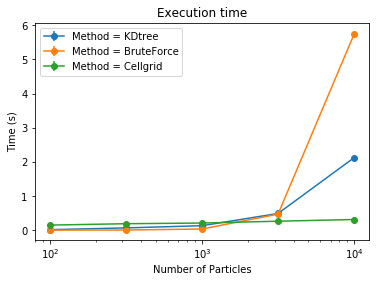

In [100]:
#Plots for visual comparison
import matplotlib
import matplotlib.pyplot as plt
for key in func_dict:
    avg_time,sd = np.array(func_dict[key][1],dtype=np.float32)[:,0],np.array(func_dict[key][1],dtype=np.float32)[:,1]
    plt.errorbar(Npoints,avg_time,yerr=sd,label='Method = {}'.format(key),fmt='-o')
    plt.legend()
    plt.xlabel('Number of Particles')
    plt.ylabel('Time (s)')
    plt.xscale('log')
    plt.title('Execution time')

In [6]:
##Benchmarking - Time ------------> Number of particles
#Setting
Npoints = np.logspace(2,5,num=20,dtype=np.int32)
box = np.array([100,100,100,90,90,90],dtype=np.float32)
maxdist = 10.0
##Benchmarks
time_kd,time_cg = [],[]
mem_kd,mem_cg = [],[]
func_dict = dict(KDtree=[kdtree_select,time_kd,mem_kd],Cellgrid=[cg_select,time_cg,mem_cg])
for num in Npoints:
    points = init_uniform(box,Npoints=num)
    for key in func_dict:
        time = %timeit -o -q -n 5 -r 3 func_dict[key][0](box,points,maxdist)
        mem = %memit -o -q func_dict[key][0](box,points,maxdist)
        func_dict[key][1].append([time.average,time.stdev])
        func_dict[key][2].append(mem.mem_usage)


NameError: name 'plt' is not defined

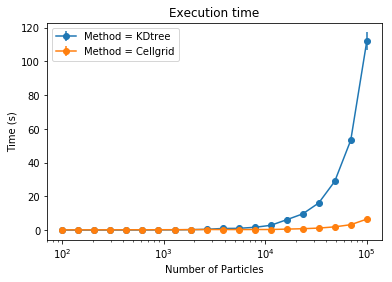

In [7]:
import matplotlib
import matplotlib.pyplot as plt        
for key in func_dict:
    avg_time,sd = np.array(func_dict[key][1],dtype=np.float32)[:,0],np.array(func_dict[key][1],dtype=np.float32)[:,1]
    plt.errorbar(Npoints,avg_time,yerr=sd,label='Method = {}'.format(key),fmt='-o')
    plt.legend()
    plt.xlabel('Number of Particles')
    plt.ylabel('Time (s)')
    plt.xscale('log')
    plt.title('Execution time')

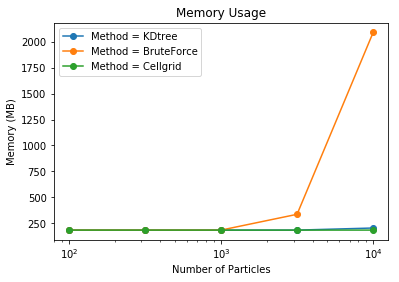

In [104]:
#Memory Usage
for key in func_dict:
    avg_mem = np.array(func_dict[key][2],dtype=np.float32)
    plt.errorbar(Npoints,avg_mem,label='Method = {}'.format(key),fmt='-o')
    plt.legend()
    plt.xlabel('Number of Particles')
    plt.ylabel('Memory (MB)')
    plt.xscale('log')
    plt.title('Memory Usage')

In [13]:
#####Benchmark for different cutoff radius and number of particles for Cellgrid
#Setting
box = np.array([100,100,100,90,90,90],dtype=np.float32)
Npoints = np.logspace(2,4,num=5,dtype=np.int32)
Maxdist = np.linspace(5,30,num=6)

In [14]:
#Benchmarks
time_cg,mem_cg = [],[]
for npt in Npoints:
    points = init_uniform(box,npt)
    for maxdist in Maxdist:
        time = %timeit -q -o -n 1 -r 3 cg_select(box,points,maxdist)
        mem = %memit -o -q cg_select(box,points,maxdist)
        time_cg.append([npt,maxdist,time.average,time.stdev])
        mem_cg.append([npt,maxdist,mem.mem_usage[0]])

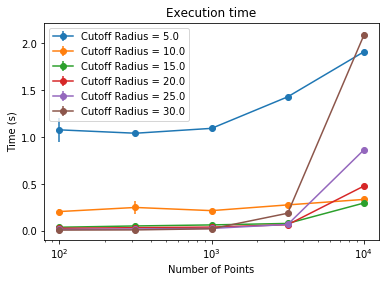

In [15]:
#Plots for visual comparison
import matplotlib
import matplotlib.pyplot as plt
arr = np.array(time_cg)
for maxdist in Maxdist:
    mask = (arr[:,1]==maxdist)
    npt,avg,sd = (arr[mask,:][:,0]),(arr[mask,:][:,2]),(arr[mask,:][:,3])
    plt.errorbar(npt,avg,yerr=sd,label='Cutoff Radius = {}'.format(maxdist),fmt='-o')
    plt.legend()
    plt.xlabel('Number of Points')
    plt.ylabel('Time (s)')
    plt.xscale('log')
    plt.title('Execution time')

Text(0.5,1,'Memory Consumption')

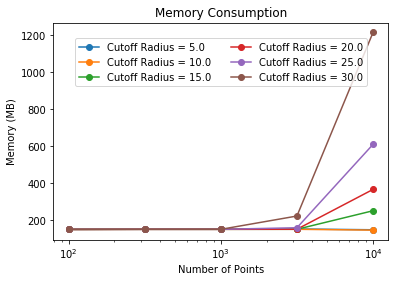

In [16]:
arr = np.array(mem_cg)
for maxdist in Maxdist:
    mask = (arr[:,1]==maxdist)
    npt,avg = (arr[mask,:][:,0]),(arr[mask,:][:,2])
    plt.errorbar(npt,avg,label='Cutoff Radius = {}'.format(maxdist),fmt='-o')   
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.95),
          ncol=2, fancybox=True)
plt.xlabel('Number of Points')
plt.ylabel('Memory (MB)')
plt.xscale('log')
plt.title('Memory Consumption')